# Ex 13: Kuiper belt object interception

We are focusing on intercepting $1994GV_9$. We are assuming that the asteroid is evolving on the same plane as the earth (the eccliptic) and orbiting the sun at 43.6AU in a circular motion.

In [166]:
import matplotlib.pyplot as plt

from space_base import GravBody, Probe
import numpy as np

# Define constants
G = 6.67e-11  # Gravitational constant
g0 = 9.80665
sun = GravBody(name="Sun", mass=1_988_500e24, radius=695_700e3)  # Sun as an object with mass and radius

# Define conversion function
def UA_to_meters(UA):
    return UA * 1.496e11
def meters_to_UA(meters):
    return meters / 1.496e11

## Long duration burn simulation

To be more realistic with our ion rocket we are not going to simulate a impulsive burn but a continuous burn. The objective is to design the burn such as it stop when the probe reach the asteroid's orbit. For that, the differential funcion use to simulate the probe needs some changes.

Z and vz will be use to store the mass of the probe as space_base do not support 4D inputs.

In [167]:
mass_lost_rate = 10e-6 # kg/s
dry_mass = 300 # dry mass of the probe
def probeqns_rocket(_, posvelmass):
    Isp = 3400 # in seconds
    if posvelmass[2] <= dry_mass:
        posvelmass[5] = 0.0
    else:
        posvelmass[5] = -mass_lost_rate

    r = np.sqrt(posvelmass[0] ** 2 + posvelmass[1] ** 2)
    f = -G * sun.mass / r ** 3
    gravity_force = f * posvelmass[0:2]
    axy = gravity_force + posvelmass[3:5]*np.abs(posvelmass[5])*g0*Isp/(posvelmass[2]*np.linalg.norm(posvelmass[3:5]))

    return posvelmass[3], posvelmass[4], posvelmass[5], axy[0], axy[1], 0.0

We then initialize our probe at Earth's orbit around sun as the L4 point is on this orbit.

In [168]:
fuel_mass = 1000 # kg
v0 = np.sqrt(G * sun.mass / UA_to_meters(1))  # initial speed
xymass0 = [UA_to_meters(1), 0, dry_mass + fuel_mass]  # start position
vxy0 = [0, v0]  # start vertical speed
tf = fuel_mass/mass_lost_rate  # Max burn time

probe = Probe(probeqns_rocket, tf, tf/3600, x0=xymass0[0], vx0=vxy0[0], 
            y0=xymass0[1], vy0=vxy0[1], z0=xymass0[2], vz0=mass_lost_rate) # probe as an object
t, posvel = probe.odesolve() # solve the differential equations

At the end of the burn this is the probe trajectory. Now, we need to implement an algorithm that will converge to find the fuel mass needed to reach the asteroid's orbit.

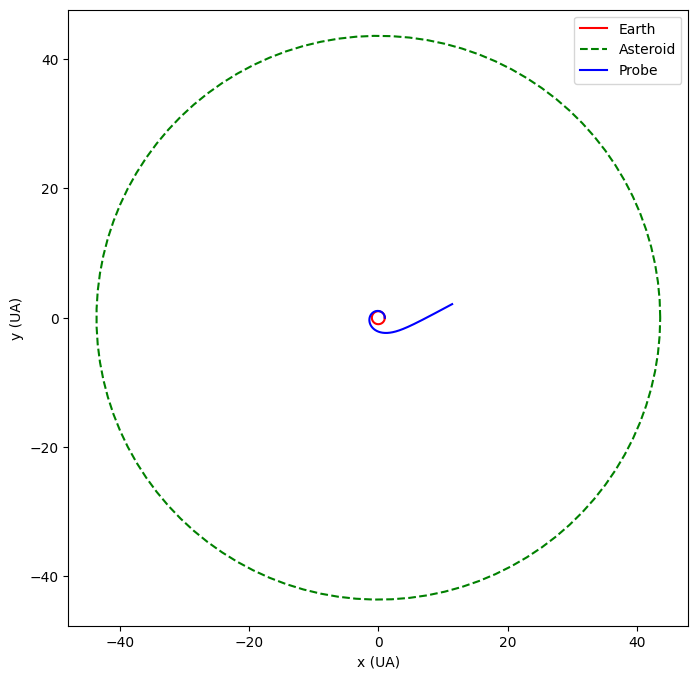

In [169]:
plt.figure(figsize=(8, 8))  # create figure, figsize can be changed as preferred

# Plotting Earth's orbit
uang = np.linspace(0, 2 * np.pi, 100)
x = np.cos(uang)
y = np.sin(uang)
plt.plot(x, y, color='red', label='Earth')
# Plotting Asteroid's orbit
uang = np.linspace(0, 2 * np.pi, 100)
x = 43.6 * np.cos(uang)
y = 43.6 * np.sin(uang)
plt.plot(x, y, color='green', linestyle="--", label='Asteroid')

plt.plot(meters_to_UA(posvel[:, 0]), meters_to_UA(posvel[:, 1]), color='blue', label="Probe") # plot the probe's orbit

plt.xlabel('x (UA)')
plt.ylabel('y (UA)')
plt.axis('equal')
plt.legend()
plt.show() # make plot appear

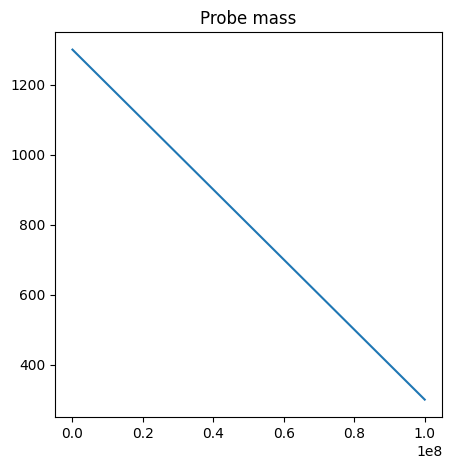

In [170]:
plt.figure(figsize=(5, 5))  # create figure, figsize can be changed as preferred
plt.title("Probe mass")
plt.plot(t, posvel[:, 2])
plt.show()

## Fuel calculation

As the starting amount of fuel will determine the final orbit the probe will reach, it is important to tune this parameter so that our probe reach the desired orbit. For that we could use a loop that will find the right starting fuel mass to reach the desire aphelion.

In [171]:
import pandas as pd

dist_to_sun = 1
fuel_mass_dist_cache = pd.DataFrame({'d': [1.0, 500.0], 'dry_mass': [0, 100000]})
fuel_mass_dist_cache.set_index('d', inplace=True)
while np.abs(dist_to_sun - 43.6) >= 0.01:
    v0 = np.sqrt(G * sun.mass / UA_to_meters(1))  # initial speed
    fuel_mass = np.interp(43.6, fuel_mass_dist_cache.index, fuel_mass_dist_cache["dry_mass"])
    xymass0 = [UA_to_meters(1), 0, dry_mass + fuel_mass]  # start position
    vxy0 = [0, v0]  # start vertical speed
    tf = fuel_mass/mass_lost_rate  # Max burn time

    probe = Probe(probeqns_rocket, tf, tf/3600, x0=xymass0[0], vx0=vxy0[0], 
                y0=xymass0[1], vy0=vxy0[1], z0=xymass0[2], vz0=mass_lost_rate) # probe as an object
    t, posvel = probe.odesolve() # solve the differential equations

    dist_to_sun = meters_to_UA(max(np.linalg.norm(posvel[:, 0:2], axis=1)))
    new_data = {'d': dist_to_sun, 'dry_mass': dry_mass}
    fuel_mass_dist_cache.loc[dist_to_sun] = fuel_mass
    fuel_mass_dist_cache = fuel_mass_dist_cache.sort_index()
    # print(f"d:{dist_to_sun}, m={dry_mass}")
fuel_mass # Fuel mass of the probe to reach the asteroid in kg

3399.801033121058

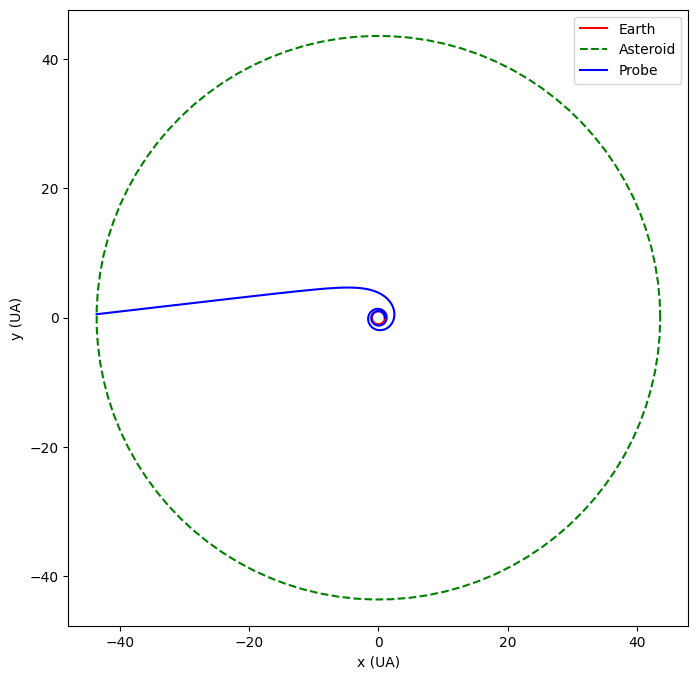

In [172]:
plt.figure(figsize=(8, 8))  # create figure, figsize can be changed as preferred

# Plotting Earth's orbit
uang = np.linspace(0, 2 * np.pi, 100)
x = np.cos(uang)
y = np.sin(uang)
plt.plot(x, y, color='red', label='Earth')
# Plotting Asteroid's orbit
uang = np.linspace(0, 2 * np.pi, 100)
x = 43.6 * np.cos(uang)
y = 43.6 * np.sin(uang)
plt.plot(x, y, color='green', linestyle="--", label='Asteroid')

# Plot probe burn trajectory
plt.plot(meters_to_UA(posvel[:, 0]), meters_to_UA(posvel[:, 1]), color='blue', label="Probe") # plot the probe's orbit

plt.xlabel('x (UA)')
plt.ylabel('y (UA)')
plt.axis('equal')
plt.legend()
plt.show() # make plot appear

In [173]:
np.linalg.norm(posvel[-1, 2:4]) / 1e3 # final speed of the probe in km/s

75.14672173003704

In [174]:
dist_to_sun = np.linalg.norm(posvel[:, 0:2], axis=1)
r_perihelion = np.min(dist_to_sun)
meters_to_UA(r_perihelion) # Perihelion distance in UA

1.0

In [175]:
r_aphelion = np.max(dist_to_sun)
meters_to_UA(r_aphelion) # Aphelion distance in UA

43.60016429216551

In [176]:
a = (r_perihelion + r_aphelion) / 2
meters_to_UA(a) # semi-major axis of the probe's orbit in UA

22.300082146082755

In [177]:
e = (r_aphelion - r_perihelion) / (r_aphelion + r_perihelion)
e # eccentricity of the probe's orbit

0.9551571158595189